In [163]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [164]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [165]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position =  1 / fcen
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [166]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [167]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )


sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [168]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

def mapping(x, eta, beta):

    return x

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


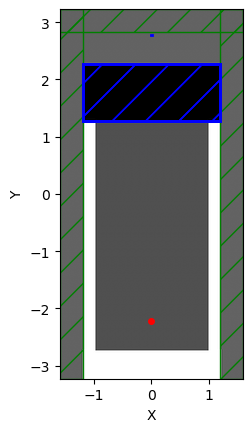

In [169]:
monitor_position, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0.01,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)

opt.plot2D(True)

In [46]:
evaluation_history = []
cur_iter = [0]
numevl = 1

def f(v, gradient, beta):
    global numevl
    print("Current iteration : {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.real(dJ_du).ravel()
        )  # backprop

    evaluation_history.append([np.max(np.real(f0))])
    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FOM : {}".format(evaluation_history))
    print("Current f0 value: {}".format(np.real(f0)))

    return np.mean(f0)

In [47]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 8
update_factor = 10
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration : 1
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000161171 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.057

run 1 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156]]
Current f0 value: 0.019799039382250156
Current iteration : 2
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
    

run 3 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727]]
Current f0 value: 0.020990981490342727
Current iteration : 3
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center 

run 5 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066]]
Current f0 value: 0.035199665036742066
Current iteration : 4
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,

run 7 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602]]
Current f0 value: 0.21618478868635602
Current iteration : 5
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant 

run 9 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678]]
Current f0 value: 0.07773390628892678
Current iteration : 6
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
       

run 11 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851]]
Current f0 value: 0.06485621112066851
Current iteration : 7
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (

run 13 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519]]
Current f0 value: 0.4653786436660519
Current iteration : 8
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
   

run 15 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398]]
Current f0 value: 0.12473197330573398
Current iteration : 9
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.09808e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
    

run 17 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057]]
Current f0 value: 0.46761989937183057
Current iteration : 10
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center =

run 19 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169]]
Current f0 value: 0.9301968825420169
Current iteration : 11
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)


run 21 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169]]
Current f0 value: 0.9301968825420169
Current iteration : 12
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,

run 23 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985]]
Current f0 value: 0.9842316961626985
Current iteration : 13
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1

run 25 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413]]
Current f0 value: 1.2218178305745413
Current iteration : 14
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)


run 27 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495]]
Current f0 value: 1.4057657445751495
Current iteration : 15
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, c

run 29 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876]]
Current f0 value: 1.505630840872876
Current iteration : 16
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,

run 31 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609]]
Current f0 value: 1.701344970853609
Current iteration : 17
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diago

run 33 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012]]
Current f0 value: 0.07976677076213012
Current iteration : 18
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectr

run 35 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478]]
Current f0 value: 1.6534789714224478
Current iteration : 19
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,

run 37 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593]]
Current f0 value: 1.7517255011052593
Current iteration : 20
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (

run 39 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622]]
Current f0 value: 1.8004950956359622
Current iteration : 21
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2

run 41 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622]]
Current f0 value: 1.8004950956359622
Current iteration : 22
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.98454

run 43 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795]]
Current f0 value: 1.820406012357795
Current iteration : 23
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, 

run 45 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685]]
Current f0 value: 1.9804438579995685
Current iteration : 24
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal

run 47 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953]]
Current f0 value: 0.2890808793542953
Current iteration : 25
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric con

run 49 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806]]
Current f0 value: 1.9451691179938806
Current iteration : 26
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
  

run 51 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543]]
Current f0 value: 2.0489238939383543
Current iteration : 27
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0

run 53 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075]]
Current f0 value: 1.6749479542863075
Current iteration : 28
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)

run 55 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152]]
Current f0 value: 2.1145923764616152
Current iteration : 29
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
    

run 57 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104]]
Current f0 value: 2.139271400770104
Current iteration : 30
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center =

run 59 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884]]
Current f0 value: 2.289848084138884
Current iteration : 31
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50


run 61 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884]]
Current f0 value: 2.289848084138884
Current iteration : 32
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x

run 63 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184]]
Current f0 value: 2.3283258124794184
Current iteration : 33
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 2D dimensions.
Computation

First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667]]
Current f0 value: 2.439187666926667
Current iteration : 34
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     bl

run 67 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297]]
Current f0 value: 0.16994499400040297
Current iteration : 35
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.2888

run 69 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453]]
Current f0 value: 1.5740719777251453
Current iteration : 36
Starting forward run...
-----------
Initializing structure...
time for choose_c

run 71 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203]]
Current f0 value: 2.4454542461271203
Current iteration : 37
Starting forward run...
-----------
Initializing structur

run 73 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194]]
Current f0 value: 2.4949205713627194
Current iteration : 38
Starting forward run...
-----------

run 75 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406]]
Current f0 value: 2.585969207581406
Current iteration : 39
Starting forwar

run 77 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651]]
Current f0 value: 0.794910503403651
Current iteration

run 79 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985]]
Current f0 value: 2.62248660824

run 81 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985]]
Current f

run 83 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.677447


Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.6774476175445105], [2.6798598725576688]]
Current f0 v

First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.6774476175445105], [2.6798598725576688], [2.6816664475348264]]
Current f0 valu

run 89 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.677447

run 91 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.677447

run 93 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.677447

First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.6774476175445105], [2.6798598725576688], [2.6816664475348264], [2.699329727957

run 97 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.677447

run 99 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.677447

run 101 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 103 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.6774476175445105], [2.6798598725576688], [2.6816664475348264], [2.699329727957

First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.6774476175445105], [2.6798598725576688], [2.6816664475348264], [2.699329727957

run 109 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 111 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 113 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 115 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 117 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.6774476175445105], [2.6798598725576688], [2.6816664475348264], [2.699329727957

run 121 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 123 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 125 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 127 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 129 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 131 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 133 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 135 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.6774476175445105], [2.6798598725576688], [2.6816664475348264], [2.699329727957

run 139 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 141 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.6774476175445105], [2.6798598725576688], [2.6816664475348264], [2.699329727957

run 145 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 147 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 149 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 151 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 153 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 155 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

run 157 finished at t = 100.01 (10001 timesteps)
Calculating gradient...
First FOM : [[0.019799039382250156], [0.020990981490342727], [0.035199665036742066], [0.21618478868635602], [0.07773390628892678], [0.06485621112066851], [0.4653786436660519], [0.12473197330573398], [0.46761989937183057], [0.9301968825420169], [0.9301968825420169], [0.9842316961626985], [1.2218178305745413], [1.4057657445751495], [1.505630840872876], [1.701344970853609], [0.07976677076213012], [1.6534789714224478], [1.7517255011052593], [1.8004950956359622], [1.8004950956359622], [1.820406012357795], [1.9804438579995685], [0.2890808793542953], [1.9451691179938806], [2.0489238939383543], [1.6749479542863075], [2.1145923764616152], [2.139271400770104], [2.289848084138884], [2.289848084138884], [2.3283258124794184], [2.439187666926667], [0.16994499400040297], [1.5740719777251453], [2.4454542461271203], [2.4949205713627194], [2.585969207581406], [0.794910503403651], [2.6224866082462985], [2.6224866082462985], [2.67744

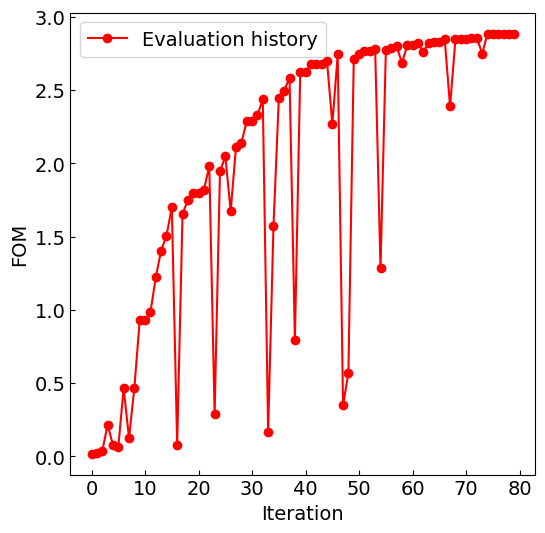

In [48]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

In [ ]:
# np.savetxt("Freeform_1.txt", design_variables.weights)

In [13]:
import numpy as np

data = np.loadtxt('Freeform_1.txt')

print("Loaded array shape:", data.shape)

opt.update_design([data])


Loaded array shape: (6171,)


In [14]:
print('Min : ', min(data))
print('Max : ',max(data))

Min :  0.03705663390703718
Max :  0.9012642168682725


     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


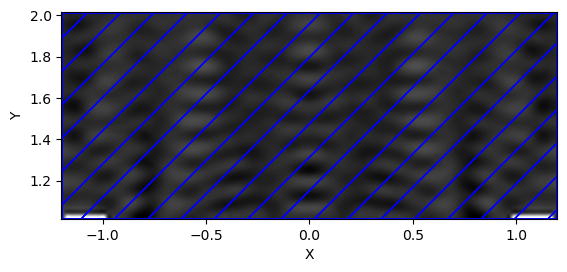

In [49]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)

     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

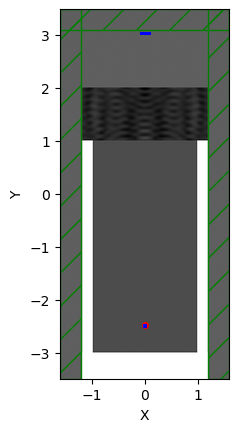

In [68]:
opt.update_design([data])

offset = 0.01
flux_size = 0.02
mn_size = 0.3*1/fcen
# mn_size = 2
monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()

In [69]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources.center, 1e-3))


-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0587599 s
time for set_conductivity = 0.00212097 

     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

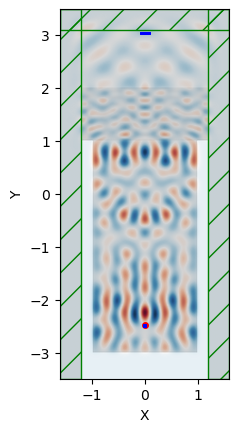

In [70]:
opt.sim.plot2D(fields = mp.Ez,
    #     field_parameters={
    #     'cmap': 'magma',    # magma 컬러맵 지정
    #     'alpha': 1,       # 필드 투명도 (0.0~1.0)
    #     'interpolation': 'none'
    # },
)

/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

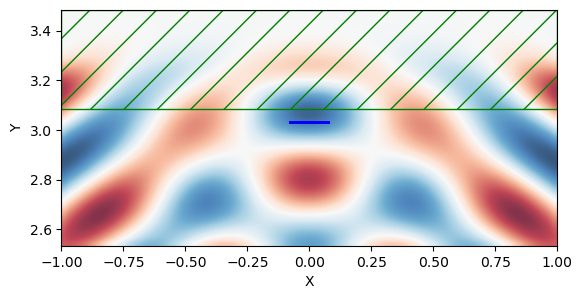

In [71]:
opt.sim.plot2D(fields = mp.Ez, output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(2, 1)
),
    # field_parameters={
    #     'cmap': 'magma',    # magma 컬러맵 지정
    #     'alpha': 1,       # 필드 투명도 (0.0~1.0)
    #     'interpolation': 'none'
    # }
)

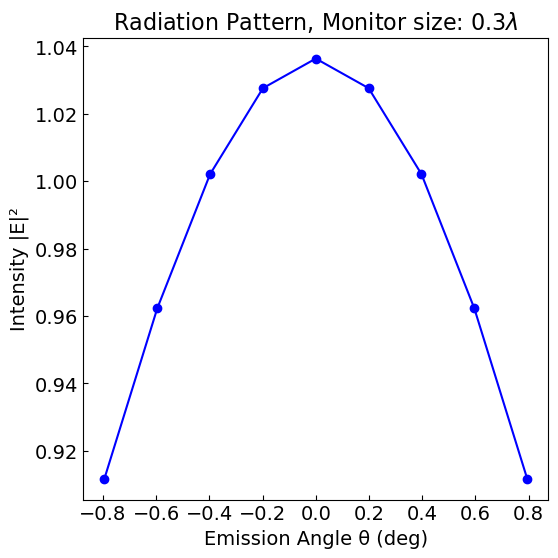

In [73]:
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리
theta = np.degrees(np.arctan2(x, z))               # rad → deg 변환

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(theta, I, 'bo-')
plt.xlabel('Emission Angle θ (deg)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
plt.title(r'Radiation Pattern, Monitor size: $0.3\lambda$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

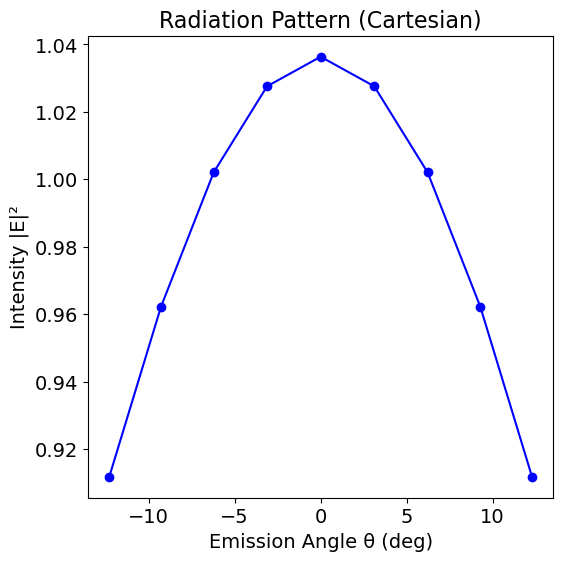

In [56]:
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)

N = len(external_field_array)
W = design_region_width

x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

theta = np.arctan2(x, z)
theta_deg = np.degrees(theta)

plt.figure(figsize = (6,6))
plt.title('Radiation Pattern (Cartesian)', fontsize=16)

plt.plot(theta_deg, np.abs(external_field_array)**2, 'bo-')
plt.ylabel('Intensity |E|²', fontsize=14)
plt.xlabel('Emission Angle θ (deg)', fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [74]:
# 1) 계산할 주파수 인덱스 (예: 첫 번째 주파수)
freq_idx = 0

# 2) DFT 모니터에서 Ez, Hx 스펙트럼 배열(복소수) 꺼내기
Ez_hat = sim.get_dft_array(dft_fields, mp.Ez, freq_idx)  # shape = (N,)
Hx_hat = sim.get_dft_array(dft_fields, mp.Hx, freq_idx)  # shape = (N,)

# 3) y-방향 Poynting 밀도 계산

Sy_density = np.real(Ez_hat * np.conj(Hx_hat))   

# 4) 모니터 축 방향 좌표 생성
L = float(monitor_size.x)      # 실제 모니터 길이 (mn_size)
N = Sy_density.size            # 샘플 포인트 개수
# x 좌표를 -L/2 ~ +L/2 로 균등 분포시킴
x = np.linspace(-L/2, L/2, N)  

# 5) 트라페zo이달(rule) 적분으로 전체 플럭스 계산
flux_total = np.trapz(Sy_density, x)  
add_flx = np.array(mp.get_fluxes(out_flux))[0]

# 6) 결과 출력
print(f"DFT monitor 적분으로 구한 total flux = {flux_total}")
print("Add flux로 계산한 total flux = ", add_flx)

err = np.abs((flux_total-add_flx)/add_flx)*100
print("오차율 (%) : ", err, "%")

DFT monitor 적분으로 구한 total flux = 0.1425270162534049
Add flux로 계산한 total flux =  0.14319631099818236
오차율 (%) :  0.4673966389999894 %


In [75]:
print("Output flux :", flux_total)
print("Input flux :", np.array(mp.get_fluxes(input_flux))[0])
print("EQE(%) :", flux_total / np.array(mp.get_fluxes(input_flux))[0] * 100, "%")

Output flux : 0.1425270162534049
Input flux : 0.5300358044479078
EQE(%) : 26.890073285117577 %


In [120]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon  # epsilon은
        self.mt = None           # m은 모멘텀 
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [121]:
evaluation_history_adam = []
beta_history = []

cur_iter = [0]

numevl = 1

lr_history=[]

uf_history=[]
t_history=[]
adjgrad_history=[]
lr_history = []

optimizer = AdamOptimizer(lr=0.02, beta1=0.9)

def f(v,eta, cur_beta):
    global numevl
    print("Current iteration: {}".format(cur_iter[0] + 1))
    
    f0_r, dJ_du0 = opt([v])
    
    f0=np.array([np.real(f0_r)])
    
    if v.size > 0:
        gradient0 = v*0
    
        gradient0[:] = dJ_du0

        gradient=gradient0
        
        adjgrad_norm = gradient.mean()
        adjgrad_history.append(adjgrad_norm) 

        # Optimize design
        updated_x, adam_lr, adam_uf, adam_m, adam_v, adam_t = optimizer.update(v, gradient)
        
        cur_beta= cur_beta+ npa.tanh((cur_beta-0.5)*0.01)
        evaluation_history_adam.append(f0_r)
        beta_history.append(cur_beta)
        cur_iter[0] = cur_iter[0] + 1
        lr_history.append(adam_lr)
        uf_history.append(adam_uf)
        t_history.append(adam_t)
        
        print("Current FoM0: {}".format(np.real(f0)))
        print("Current_beta:{}".format(cur_beta))
        
        return updated_x, adam_m, adam_v, cur_beta

In [122]:
total_iter = 50
cur_beta=1
n=Nx*Ny
x=np.ones(n)*0.5

for iters in range(total_iter):
    x, adam_m, adam_v, cur_beta = f(x,eta_i,cur_beta)

Current iteration: 1
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.46 x 0 with resolution 50
     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.051188 s
time for set_

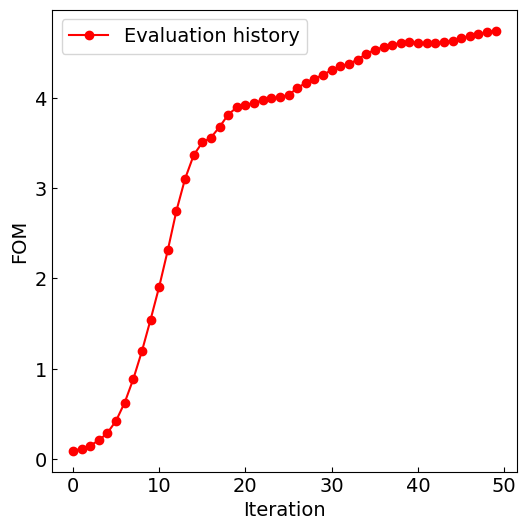

In [132]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history_adam, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

In [ ]:
# np.savetxt("adam_weights_1lambda_pos.txt", design_variables.weights)

In [177]:
import numpy as np

data = np.loadtxt('adam_weights_1lambda_pos.txt')

print("Loaded array shape:", data.shape)

opt.update_design([data])
# data


Loaded array shape: (6171,)


     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


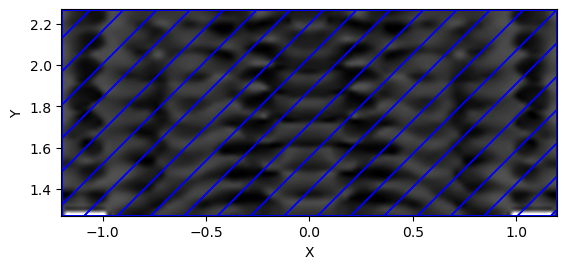

In [178]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

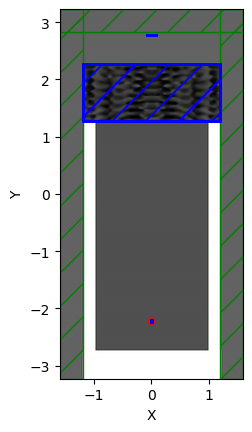

In [179]:
offset = 0.01
flux_size = 0.02
mn_size = 0.3*1/fcen

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.46 x 0 with resolution 50
     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.05353 s
time for set_conductivity = 0.00195789 s
time for set_condu

<Axes: xlabel='X', ylabel='Y'>

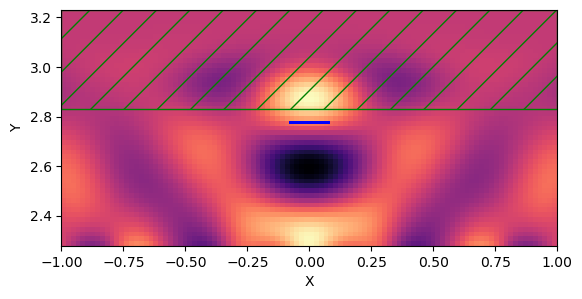

In [180]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources.center, 1e-3))

opt.sim.plot2D(fields = mp.Ez, output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(2, 1)
),
    field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 1,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

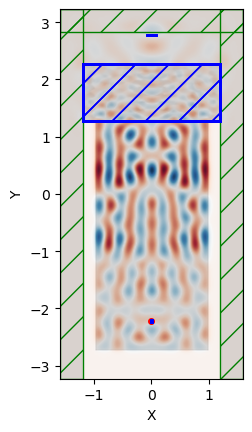

In [181]:
opt.sim.plot2D(fields = mp.Ez)

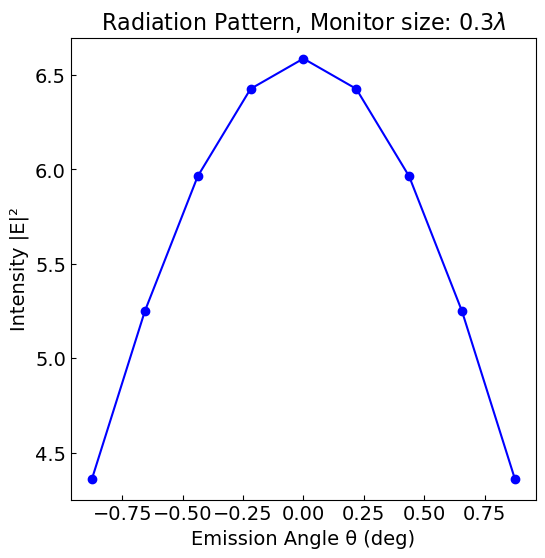

In [182]:
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리
theta = np.degrees(np.arctan2(x, z))               # rad → deg 변환

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(theta, I, 'bo-')
plt.xlabel('Emission Angle θ (deg)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
plt.title(r'Radiation Pattern, Monitor size: $0.3\lambda$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()